## Core

- Measure fluxes from a region at multiple frequencies



In [12]:
import numpy as np
from astropy.io import ascii, fits
import fluxInt
import pbCorr
import synCl
import convRegr
from prettytable import PrettyTable
import shutil,os, string
import fitSource

from matplotlib import pyplot as plt

ftSrc = fitSource.fitSrc()
fint = fluxInt.flInt()

#rootdir
#rootDir = '/Users/maccagni/Projects/MFS/FornaxA/contData/kore/'
rootDir = '/home/maccagni/Projects/MFS/FornaxA/contData/core/'

#label

aut='F8'

subRegions = ['cjet/','centre/','jet/']
labelReg = ['cj','c','j']
jCount = [5,4,4]

imDir = rootDir+'inIms/'
fint.rootdir = imDir

regDir = imDir+'inReg/'
outTabs = rootDir+'outTabs/'
figDir = rootDir+'coreFigs/'

#input image
inIm = imDir+'Meer_1440MHz_pbcorr_cutCtr.fits'
noise = 0.
errFlux = 15.

#output table 
outTable2D = outTabs+'jCjFluxWidth2D.tbl'
outTable1D = outTabs+'jCjFluxWidth1D.tbl'


print '''\t+---------+\n\t Inputs loaded\n\t+---------+'''


	+---------+
	 Inputs loaded
	+---------+


In [13]:
#-------------------------------------------------#
# Jet and counter-jet analysis
#-------------------------------------------------#

datas,heads = fint.openFile(inIm)
#Regions where to measure flux
if os.path.exists(outTable2D):
    os.remove(outTable2D)
if os.path.exists(outTable1D):
    os.remove(outTable1D)
fr=[]
flIntBeamArray=[]
flErrBeamArray=[]
flIntOutArray=[]
flErrOutArray=[]

for i in xrange(0,len(subRegions)):
    
    for j in xrange(0,jCount[i]):
        dd = datas.copy()
        
        region = regDir+subRegions[i]+labelReg[i]+str(j)+'.reg'

        maskedData, background, rms, pixels=fint.maskDatReg(dd,heads,region,noise)
        
        fits.writeto(rootDir+str(i)+'_mask_jCj.fits',maskedData,heads,overwrite=True)

        maskedData[maskedData==0.0] = np.nan

        fluxint, numPixBeam =fint.measFlux(maskedData,heads,errFlux,'none')
        peakIm = np.nanmax(maskedData)
        
        maskedData[np.isnan(maskedData)] = 0.0
        

        params2D = ftSrc.gaus2Dfit(maskedData)
        
        compressedData = np.sum(maskedData,axis=1)
                
        params1D = ftSrc.gaus1Dfit(compressedData)
        
        params2D = np.insert(params2D,0,fluxint)
        params2D = np.insert(params2D,0,peakIm)

        params1D = np.insert(params1D,0,fluxint)
        params1D = np.insert(params1D,0,peakIm)

        
        regionName =  string.split(region,'/')[-1]
        t = ftSrc.writeGaus2DfitTable(regionName,outTable2D,params2D)
        #print t
        t = ftSrc.writeGaus1DfitTable(regionName,outTable1D,params1D)
        print t

print '''\t+---------+\n\t Flux & size variation along jet\n\t+---------+'''
  

0.0017870358807064474
0.0017848306291744218
+------------+------------------------+-----------------------+-----------------------+-------------------+--------------------+
| RegionName |        IntFlux         |         PeakIm        |        PeakGaus       |      centre X     |      width X       |
+------------+------------------------+-----------------------+-----------------------+-------------------+--------------------+
|  cj0.reg   | 0.00036076295424524493 | 0.0028366834041696903 | 0.0017870358807064474 | 44.66010510941193 | 6.8396386309022965 |
+------------+------------------------+-----------------------+-----------------------+-------------------+--------------------+
0.004731099170075783
0.0047141326365552376
+------------+-----------------------+----------------------+----------------------+-------------------+-------------------+
| RegionName |        IntFlux        |        PeakIm        |       PeakGaus       |      centre X     |      width X      |
+------------+----

In [14]:
#-------------------------------------------------#
# Jet and counter-jet flux ratio
#-------------------------------------------------#
def splitter(A):
    B = A[0:len(A)//2]
    C = A[len(A)//2:]

    return (B,C)

#-------------------------------------------------#
# Plot 
#-------------------------------------------------#
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator
from matplotlib import transforms as mtransforms


def RjRp(rp,rj,outfile):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize =(12,12))
    fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(1, 1)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlabel(r'$P_{1.4 GHz}$ (r)')
    ax1.set_ylabel(r'$P_j/P_{cj}$ (r)')
    
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    #ax1.set_xscale("log", nonposx='clip')
    #ax1.set_yscale("log", nonposy='clip')
    #ax1.set_ylim([1e-1,2e3])
    #ax1.set_xlim([0.2,5e2])
    ax1.tick_params(axis='both', which='major', pad=5)

    #POINTS
    m,b = np.polyfit(rp, rj, 1) 
    print m, b, -1./4.
    # MODELS
    x = np.linspace(np.min(rp),np.max(rp),1e3)
    y = np.power(x,-1./4.)
#    idx_max = (np.abs(mod1_CI[0] - 5e5)).argmin()
#    idx_min = (np.abs(mod1_CI[0] - 30)).argmin()

    ax1.plot(rp,rj,lw=3, marker='o', color='black', linestyle='-',alpha=1)
    ax1.plot(x,x*m+b,lw=3, marker=' ', color='red', linestyle='--',alpha=1)
    ax1.plot(x,x*-4.+90.5,lw=3, marker=' ', color='blue', linestyle='--',alpha=1)

    #ax1.fill_between(b, tsErrInf, tsErrSup, facecolor='red', alpha=0.3)
    
    #ax1.plot(b,tBuoy,lw=3, marker=' ', color='blue', linestyle='--',label=r't$_{\rm buoy}$',alpha=1)
 
    #ax1.fill_between(b, tBuoyInf, tBuoySup, facecolor='blue', alpha=0.3)

    #legend = plt.legend(loc=3, prop={'size': 30})
    #legend.get_frame().set_edgecolor('black')

    # Save figure to file
    plt.savefig(outfile,overwrite = True)


print '\n\t-----> Loaded <-----'


	-----> Loaded <-----


RegionName
----------
    c2.reg
    c3.reg
    j0.reg
    j1.reg
    j2.reg
    j3.reg ['c0.reg' 'cj4.reg' 'cj3.reg' 'cj2.reg' 'cj1.reg' 'cj0.reg']
0.1593472513073585
0.1761127448765858
0.18925534653034431
0.19641437878404322
0.199255008955663
0.19994037938428144
j3.reg cj0.reg
0.00025795528050918216 0.00027813882748394886
j2.reg cj1.reg
0.0013562433979568244 0.0009010416755647569
j1.reg cj2.reg
0.004601227118373439 0.001969226185184214
j0.reg cj3.reg
0.00730415136619569 0.002789028181678605
c3.reg cj4.reg
0.008401341945317652 0.0032396003961448713
c2.reg c0.reg
0.03242588412558114 0.014003847931267317
[22.090545233835318, 22.13399144341446, 22.165248814729292, 22.181373935149498, 22.18760990509297, 22.18910116925265] [2.3154981605578366, 2.5933266199483307, 2.6188876161873744, 2.3365660851919916, 1.5051949701513587, 0.9274335512328588]
-9.40310196377177 210.40321486582607 -0.25


/home/maccagni/programs/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


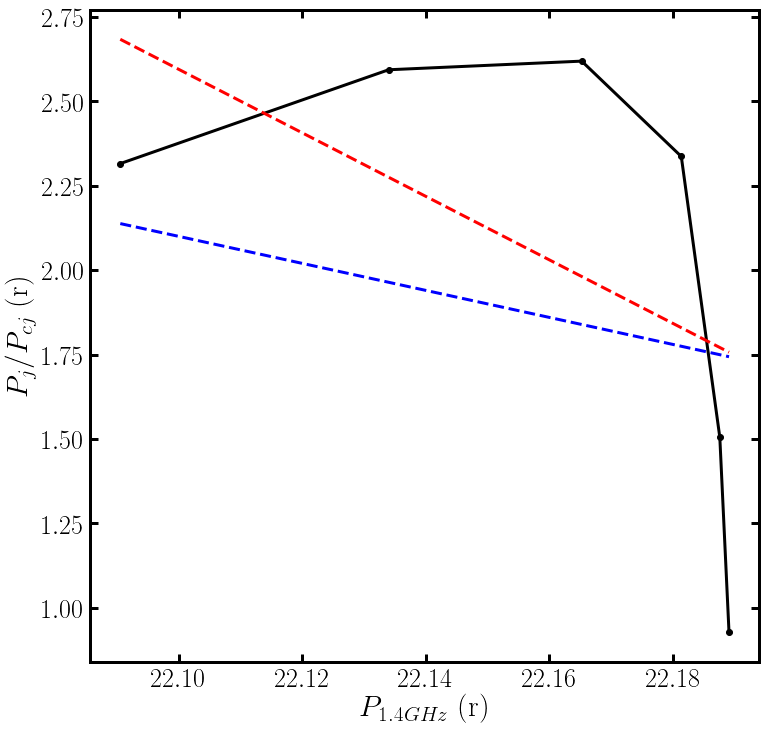

In [15]:
table= ascii.read(outTable2D)

radioPower = []
flCtr = table['IntFlux'][6]
table.remove_row(6)

b,c = splitter(table.columns[0])
tableCJ = table[0:len(b)]
tableCJrev = np.flip(tableCJ)
tableJ = table[len(b):]

DL = 25.4182*3.085678e24*1e-2

fluxTot = tableJ['IntFlux']+tableCJrev['IntFlux']
print tableJ['RegionName'], tableCJrev['RegionName']
for i in xrange(0,len(tableJ.columns[0])):
    
    if i == 0:
        fluxProg = fluxTot[i] + flCtr
    else:
        fluxProg = np.sum(fluxTot[:i+1]) + flCtr
    print fluxProg
    
    radioPower.append(np.log10(pow(10,-26)*fluxProg*4*np.pi*(DL**2)))

tableJ = np.flip(tableJ)
gaussPowerRatio = []
for i in xrange(0,len(b)):
    print tableJ['RegionName'][i], tableCJ['RegionName'][i]
    print tableJ['PeakGaus'][i], tableCJ['PeakGaus'][i]
    gaussFluxRatio = tableJ['PeakGaus'][i]/ tableCJ['PeakGaus'][i]
    imFluxRatio = tableJ['PeakIm'][i]/ tableCJ['PeakIm'][i]
    
    gaussPowerRatio.append(gaussFluxRatio)
    
#gaussPowerRatio.append(1)

#gaussPowerRatio = np.insert(gaussPowerRatio,0,1)    

print radioPower, gaussPowerRatio[::-1]

outFig = figDir +'jetRatio_radiopower.png'
RjRp(radioPower,gaussPowerRatio[::-1],outFig)

In [16]:
def brightRadius(radius,brightJet, brightCJet,outfile):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize =(12,12))
    fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(1, 1)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlabel(r'distance from core [arcsec]')
    ax1.set_ylabel(r'$I$ [Jy]')
    
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    #ax1.set_xscale("log", nonposx='clip')
    #ax1.set_yscale("log", nonposy='clip')
    #ax1.set_ylim([1e-1,2e3])
    #ax1.set_xlim([0.2,5e2])
    ax1.tick_params(axis='both', which='major', pad=5)

    #POINTS
    #m,b = np.polyfit(rp, rj, 1) 
    #print m, b, -1./4.
    # MODELS
    #x = np.linspace(np.min(rp),np.max(rp),1e3)
    #y = np.power(x,-1./4.)
#    idx_max = (np.abs(mod1_CI[0] - 5e5)).argmin()
#    idx_min = (np.abs(mod1_CI[0] - 30)).argmin()

    ax1.plot(radius,brightJet,lw=3, marker='o', color='blue', linestyle='-',label='jet',alpha=1)
    ax1.plot(radius,brightCJet,lw=3, marker='o', color='red', linestyle='-',label='counter-jet',alpha=1)

    #ax1.plot(x,x*m+b,lw=3, marker=' ', color='red', linestyle='--',alpha=1)
    #ax1.plot(x,x*-4.+90.5,lw=3, marker=' ', color='blue', linestyle='--',alpha=1)

    #ax1.fill_between(b, tsErrInf, tsErrSup, facecolor='red', alpha=0.3)
    
    #ax1.plot(b,tBuoy,lw=3, marker=' ', color='blue', linestyle='--',label=r't$_{\rm buoy}$',alpha=1)
 
    #ax1.fill_between(b, tBuoyInf, tBuoySup, facecolor='blue', alpha=0.3)

    legend = plt.legend(loc=1, prop={'size': 30})
    legend.get_frame().set_edgecolor('black')

    # Save figure to file
    plt.savefig(outfile,overwrite = True)

def sizeRadius(radius,size1, size2,outfile):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize =(12,12))
    fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(1, 1)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlabel(r'distance from core [arcsec]')
    ax1.set_ylabel(r'$FWHM$ [arcsec]')
    
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    #ax1.set_xscale("log", nonposx='clip')
    #ax1.set_yscale("log", nonposy='clip')
    #ax1.set_ylim([1e-1,2e3])
    #ax1.set_xlim([0.2,5e2])
    ax1.tick_params(axis='both', which='major', pad=5)

    #POINTS
    #m,b = np.polyfit(rp, rj, 1) 
    #print m, b, -1./4.
    # MODELS
    #x = np.linspace(np.min(rp),np.max(rp),1e3)
    #y = np.power(x,-1./4.)
#    idx_max = (np.abs(mod1_CI[0] - 5e5)).argmin()
#    idx_min = (np.abs(mod1_CI[0] - 30)).argmin()

    ax1.plot(radius,size2,lw=3, marker='o', color='blue', linestyle='-',label='jet',alpha=1)
    
    ax1.plot(radius,size1,lw=3, marker='o', color='red', linestyle='-',label='counter-jet',alpha=1)

    #ax1.plot(x,x*m+b,lw=3, marker=' ', color='red', linestyle='--',alpha=1)
    #ax1.plot(x,x*-4.+90.5,lw=3, marker=' ', color='blue', linestyle='--',alpha=1)

    #ax1.fill_between(b, tsErrInf, tsErrSup, facecolor='red', alpha=0.3)
    
    #ax1.plot(b,tBuoy,lw=3, marker=' ', color='blue', linestyle='--',label=r't$_{\rm buoy}$',alpha=1)
 
    #ax1.fill_between(b, tBuoyInf, tBuoySup, facecolor='blue', alpha=0.3)

    legend = plt.legend(loc=1, prop={'size': 30})
    legend.get_frame().set_edgecolor('black')

    # Save figure to file
    plt.savefig(outfile,overwrite = True)
print '\n\t-----> Loaded <-----'

def ratioRadius(radius, ratio, outfile):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize =(12,12))
    fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(1, 1)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0])
    ax1.set_xlabel(r'distance from core [arcsec]')
    ax1.set_ylabel(r'$I_{\rm jet}/I_{\rm c-jet}$')
    
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    #ax1.set_xscale("log", nonposx='clip')
    #ax1.set_yscale("log", nonposy='clip')
    #ax1.set_ylim([1e-1,2e3])
    #ax1.set_xlim([0.2,5e2])
    ax1.tick_params(axis='both', which='major', pad=5)

    #POINTS
    #m,b = np.polyfit(rp, rj, 1) 
    #print m, b, -1./4.
    # MODELS
    #x = np.linspace(np.min(rp),np.max(rp),1e3)
    #y = np.power(x,-1./4.)
#    idx_max = (np.abs(mod1_CI[0] - 5e5)).argmin()
#    idx_min = (np.abs(mod1_CI[0] - 30)).argmin()

    ax1.scatter(radius,ratio,lw=3, marker='o', color='black', linestyle='-',label='Brigthness ratio',alpha=1)
    
    #ax1.plot(radius,size1,lw=3, marker='o', color='red', linestyle='-',label='counter-jet',alpha=1)

    #ax1.plot(x,x*m+b,lw=3, marker=' ', color='red', linestyle='--',alpha=1)
    #ax1.plot(x,x*-4.+90.5,lw=3, marker=' ', color='blue', linestyle='--',alpha=1)

    #ax1.fill_between(b, tsErrInf, tsErrSup, facecolor='red', alpha=0.3)
    
    #ax1.plot(b,tBuoy,lw=3, marker=' ', color='blue', linestyle='--',label=r't$_{\rm buoy}$',alpha=1)
 
    #ax1.fill_between(b, tBuoyInf, tBuoySup, facecolor='blue', alpha=0.3)

    #legend = plt.legend(loc=1, prop={'size': 30})
    #legend.get_frame().set_edgecolor('black')

    # Save figure to file
    plt.savefig(outfile,overwrite = True)
    
    
def widthRatioPlot(width, ratio, outfile):

    params = {'font.family'         :' serif',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 30.0,
              'axes.linewidth'      : 3,
              'lines.linewidth'     : 3,
              'xtick.labelsize'     : 26,
              'ytick.labelsize'     : 26, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 8,
              'xtick.major.width'   : 3,
              'xtick.minor.size'    : 4,
              'xtick.minor.width'   : 2,
              'ytick.major.size'    : 8,
              'ytick.major.width'   : 3,
              'ytick.minor.size'    : 4,
              'ytick.minor.width'   : 2, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize =(12,12))
    fig.subplots_adjust(hspace=0.0)
    gs = gridspec.GridSpec(1, 1)
    plt.rc('xtick')


    # Initialize subplots
    ax1 = fig.add_subplot(gs[0])
    ax1.set_ylabel(r'$FWHM_{\rm jet} / FWHM_{\rm c-jet}$')
    ax1.set_xlabel(r'$I_{\rm jet}/I_{\rm c-jet}$')
    
    #ax1.set_xscale("symlog", nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale("symlog", nonposy='clip', linthreshy=0.1)
    #ax1.set_xscale("log", nonposx='clip')
    #ax1.set_yscale("log", nonposy='clip')
    #ax1.set_ylim([1e-1,2e3])
    #ax1.set_xlim([0.2,5e2])
    ax1.tick_params(axis='both', which='major', pad=5)

    #POINTS
    #m,b = np.polyfit(rp, rj, 1) 
    #print m, b, -1./4.
    # MODELS
    #x = np.linspace(np.min(rp),np.max(rp),1e3)
    #y = np.power(x,-1./4.)
#    idx_max = (np.abs(mod1_CI[0] - 5e5)).argmin()
#    idx_min = (np.abs(mod1_CI[0] - 30)).argmin()

    ax1.plot(ratio,width,lw=3, marker='o', color='black', linestyle='-',label='Width ratio / Brighthess ratio',
                alpha=1)
    
    #ax1.plot(radius,size1,lw=3, marker='o', color='red', linestyle='-',label='counter-jet',alpha=1)

    #ax1.plot(x,x*m+b,lw=3, marker=' ', color='red', linestyle='--',alpha=1)
    #ax1.plot(x,x*-4.+90.5,lw=3, marker=' ', color='blue', linestyle='--',alpha=1)

    #ax1.fill_between(b, tsErrInf, tsErrSup, facecolor='red', alpha=0.3)
    
    #ax1.plot(b,tBuoy,lw=3, marker=' ', color='blue', linestyle='--',label=r't$_{\rm buoy}$',alpha=1)
 
    #ax1.fill_between(b, tBuoyInf, tBuoySup, facecolor='blue', alpha=0.3)

    #legend = plt.legend(loc=1, prop={'size': 30})
    #legend.get_frame().set_edgecolor('black')

    # Save figure to file
    plt.savefig(outfile,overwrite = True)
print '\n\t-----> Loaded <-----'
    
print '\n\t-----> Loaded <-----'


	-----> Loaded <-----

	-----> Loaded <-----

	-----> Loaded <-----



	-----> Loaded <-----


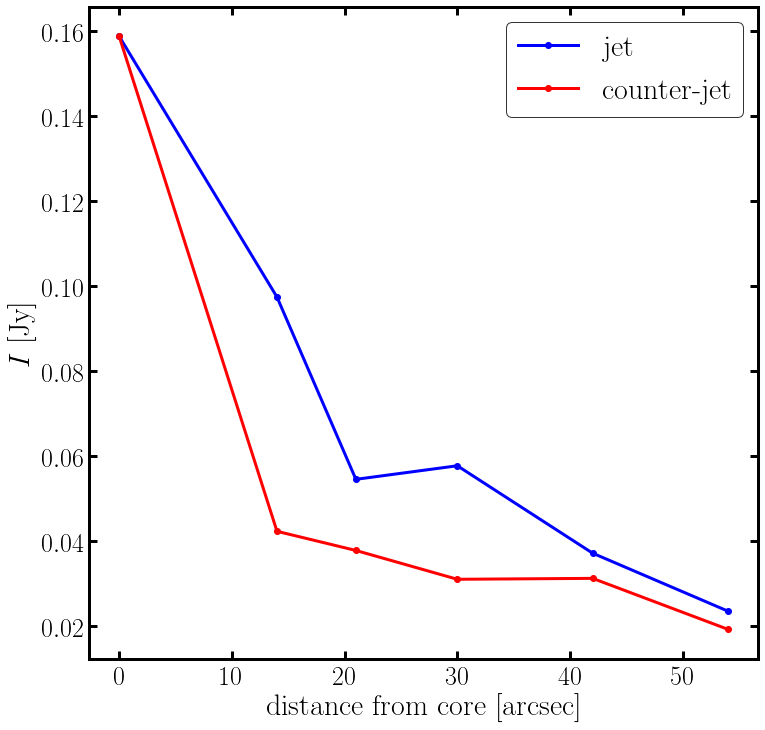

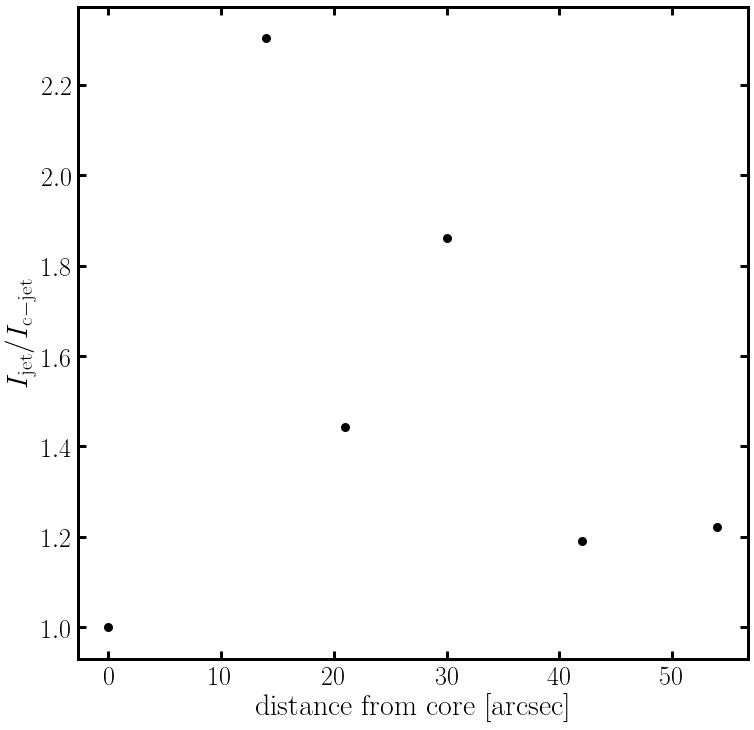

In [17]:
datas,heads = fint.openFile(inIm)

table= ascii.read(outTable1D)


width = table['width X']*2.355
widthBeam = heads['BMAJ']/heads['CDELT2']
widthReal = np.sqrt(np.power(width,2)-np.power(widthBeam,2))

surfBright = table['PeakIm']*np.sqrt((np.power(widthReal,2)/np.power(widthBeam,2)+1))

widthReal *= heads['CDELT2']
widthReal *= 3600.

table.add_column(surfBright, name='surfaceBrightness')
table.add_column(widthReal, name='deconvolvedWidth')
                                     
b,c = splitter(table.columns[0])
tableCJ = table[0:len(b)+1]
tableCJrev = np.flip(tableCJ)
tableJ = table[len(b):]

surfBright1 = tableCJrev['surfaceBrightness']
surfBright2 = tableJ['surfaceBrightness']

surfRatio = surfBright2/surfBright1
radius = [0,14,21,30,42,54,63]
                                     
outFig = figDir +'brightnessRadius.png'

brightRadius(radius[0:-1],surfBright2[0:-1],surfBright1[0:-1],outFig)    

outFig = figDir +'ratioBrigthRadius.png'

ratioRadius(radius[0:-1],surfRatio[0:-1],outFig)  

print '\n\t-----> Loaded <-----'

RegionName
----------
    c1.reg
    c2.reg
    c3.reg
    j0.reg
    j1.reg
    j2.reg
    j3.reg
['c1.reg' 'c0.reg' 'cj4.reg' 'cj3.reg' 'cj2.reg' 'cj1.reg' 'cj0.reg']


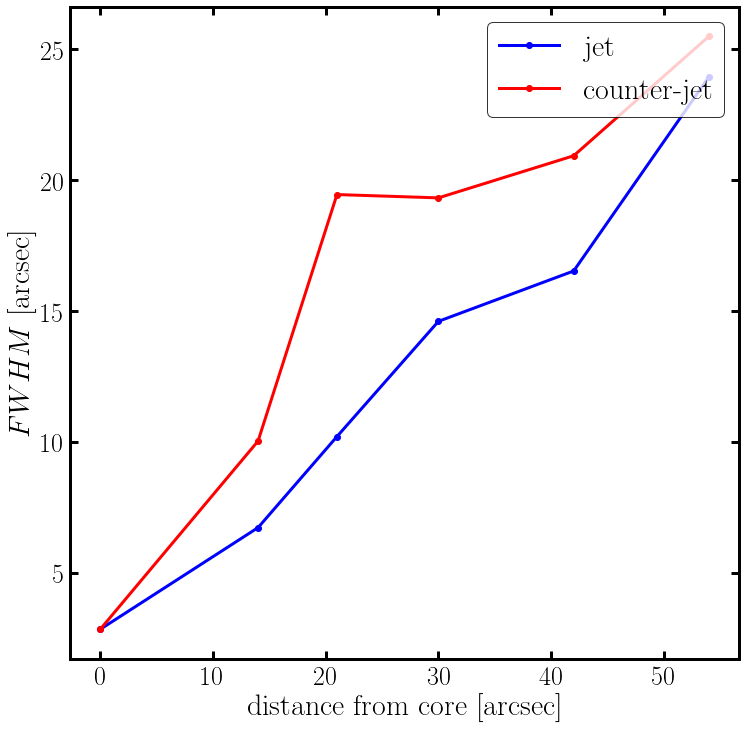

In [18]:
b,c = splitter(table.columns[0])
tableCJ = table[0:len(b)+1]
tableCJrev = np.flip(tableCJ)
print tableJ['RegionName']
print tableCJrev['RegionName']

tableJ = table[len(b):]
width1 = tableCJrev['deconvolvedWidth']
width2 = tableJ['deconvolvedWidth']

widthRatio = np.divide(width2,width1)

radius = [0,14,21,30,42,54,63]
                                     
outFig = figDir +'widthRadius.png'

sizeRadius(radius[0:-1],width1[0:-1],width2[0:-1],outFig)       

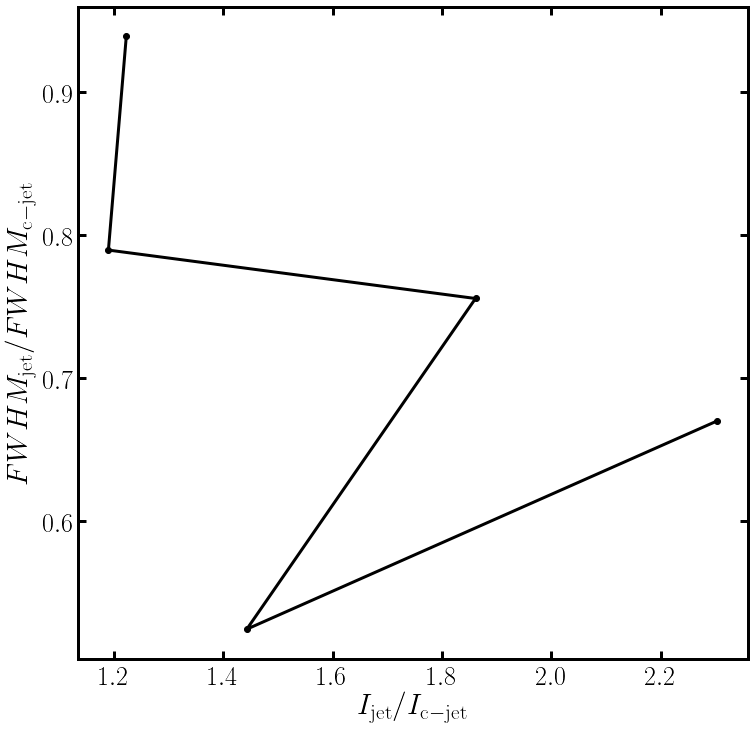

In [19]:
outFig = figDir +'widthRatio.png'

wr = np.array(widthRatio[0:-1],dtype='float32')
sr = np.array(surfRatio[0:-1],dtype='float32')

widthRatioPlot(wr[1:],sr[1:],outFig)     